In [1]:
import sys
sys.path.append('../..')
from delphi import train
from delphi.utils import model_utils
from delphi import grad
from delphi import oracle
from delphi.utils.datasets import CIFAR
import delphi.utils.constants as consts
import delphi.utils.data_augmentation as da
from delphi.utils.helpers import setup_store_with_metadata

import torchvision 
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import torch as ch
import torch.nn as nn
from torch import Tensor
from torch.distributions import Gumbel
import math
import numpy as np
import matplotlib.pyplot as plt
import cox
from cox.utils import Parameters
import cox.store as store
from cox.readers import CollectionReader
import seaborn as sns
import os
import config
import pickle
import pandas as pd

# set environment variable so that stores can create output files
os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'

# noise distributions
gumbel = Gumbel(0, 1)
num_classes = 10

# file path constants
PRETRAIN = '/home/gridsan/stefanou/cifar-10/resnet-18/pretrained_model'
BASE_CLASSIFIER = '/home/gridsan/stefanou/cifar-10/resnet-18/base_constant_1e-1'
BASE_CLASSIFIER_PATH = BASE_CLASSIFIER + '/ee9b9c47-426e-4d3b-861c-2c72958fbbbe/checkpoint.pt.latest'
LOGIT_BALL_CLASSIFIER = '/home/gridsan/stefanou/cifar-10/resnet-18/constant_trunc_1e-1'
STANDARD_CLASSIFIER = '/home/gridsan/stefanou/cifar-10/resnet-18/constant_standard_1e-1'
DATA_PATH = '/home/gridsan/stefanou/data/'
TRUNC_TRAIN_DATASET = 'trunc_train_calibrated_logit_'
TRUNC_VAL_DATASET = 'trunc_val_calibrated_logit_'
TRUNC_TEST_DATASET = 'trunc_test_calibrated_logit_'

# helper dataset
class TruncatedCIFAR(Dataset):
    """
    Truncated CIFAR-10 dataset [Kri09]_.
    Original dataset has 50k training images and 10k testing images, with the
    following classes:
    * Airplane
    * Automobile
    * Bird
    * Cat
    * Deer
    * Dog
    * Frog
    * Horse
    * Ship
    * Truck
    .. [Kri09] Krizhevsky, A (2009). Learning Multiple Layers of Features
        from Tiny Images. Technical Report.
        
    Truncated dataset only includes images and labels from original dataset that fall within the truncation set.
    """
    def __init__(self, img, label, transform = None):
        """
        """
        self.img = img 
        self.label = label
        self.transform = transform

    def __getitem__(self, idx):
        """
        """
        x = self.img[idx]
        y = self.label[idx]
        # data augmentation
        if self.transform: 
            x = self.transform(x)
            
        return x, y
    
    def __len__(self): 
        return self.img.size(0)
transform_ = transforms.Compose(
    [transforms.ToTensor()])

# hyperparameters
args = Parameters({ 
    'epochs': 25,
    'workers': 8, 
    'batch_size': 128, 
    'lr': 1e-2, 
    'accuracy': True,
    'momentum': 0.9, 
    'weight_decay': 5e-4, 
    'save_ckpt_iters': 25,
    'should_save_ckpt': True,
    'log_iters': 1,
    'validation_split': .8,
    'shuffle': True,
    'parallel': False, 
    'num_samples': 1000,
    'logit_ball': 7.5,
    'trials': 5,
    'temperature': nn.Parameter(ch.ones(1).cuda()),
    'device': 'cuda' if ch.cuda.is_available() else 'cpu'
})

# Setup and Explore Dataset

In [2]:
ds = CIFAR(data_path='/home/gridsan/stefanou/data')

In [3]:
import torchvision 

ds = CIFAR(data_path='/home/gridsan/stefanou/data')

dataset = torchvision.datasets.CIFAR10(root='/home/gridsan/stefanou/data', train=True,
                                        download=False, transform=transform_)

train_set, val_set = ch.utils.data.random_split(dataset, [45000, 5000])

train_loader = ch.utils.data.DataLoader(train_set, batch_size=128,
                                          shuffle=True, num_workers=2)

val_loader = ch.utils.data.DataLoader(val_set, batch_size=128,
                                          shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='/home/gridsan/stefanou/data', train=False,
                                       download=False, transform=transform_)
test_loader = ch.utils.data.DataLoader(test_set, batch_size=128,
                                         shuffle=False, num_workers=2)

label: bird


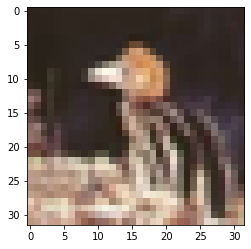

label: deer


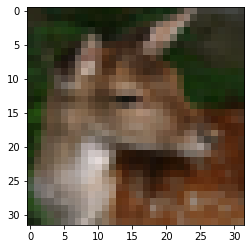

label: frog


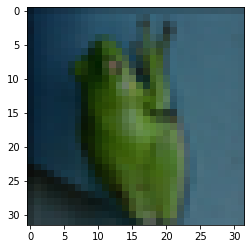

label: automobile


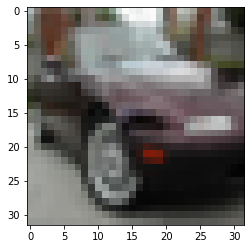

label: ship


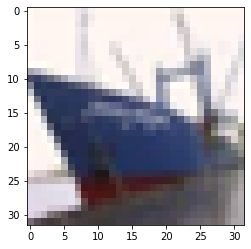

label: airplane


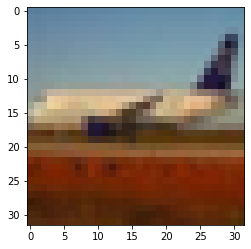

label: cat


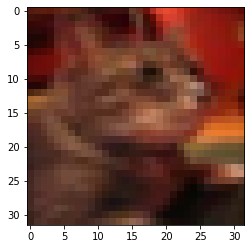

label: truck


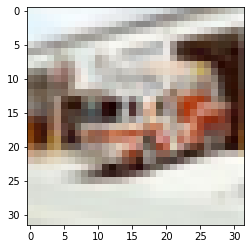

label: dog


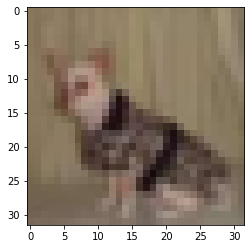

label: horse


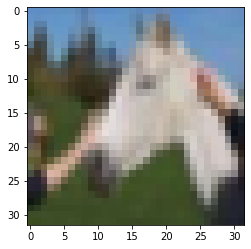

In [4]:
labels = {i for i in range(10)}
for image, target in train_loader: 
    for j in range(len(target)): 
        im, targ = image[j], target[j]
        if targ.item() in labels: 
            print("label: {}".format(da.CIFAR_LABELS[targ.item()]))
            plt.imshow(transforms.ToPILImage(mode="RGB")(im.squeeze(0)))
            plt.show()
            labels.remove(targ.item())
        if len(labels) == 0: 
            break

# Train Base Classifier

In [5]:
base_classifier, _ = model_utils.make_and_restore_model(arch='resnet18', dataset=ds)
out_store = store.Store(BASE_CLASSIFIER)

Logging in: /home/gridsan/stefanou/cifar-10/resnet-18/base_constant_1e-1/b5f22ea9-29ae-4fe8-8407-4b0a53f50afc


In [6]:
# train
ch.manual_seed(0)
train.train_model(args, base_classifier, (train_loader, val_loader), store=out_store)
out_store.close()

KeyboardInterrupt: 

In [85]:
reader = CollectionReader(BASE_CLASSIFIER)
logs = reader.df('logs')
reader.close()
logs.head()

100%|██████████| 1/1 [00:00<00:00, 145.53it/s]


,epoch,val_prec1,val_loss,train_prec1,train_loss,time,exp_id
0,1,45.919998,1.504802,37.017776,1.736704,14.699303,ee9b9c47-426e-4d3b-861c-2c72958fbbbe
1,2,60.099998,1.117035,55.068890,1.230530,29.374748,ee9b9c47-426e-4d3b-861c-2c72958fbbbe
2,3,66.839996,0.957898,66.548889,0.944095,44.123084,ee9b9c47-426e-4d3b-861c-2c72958fbbbe
3,4,70.619995,0.827475,74.257782,0.736036,58.861183,ee9b9c47-426e-4d3b-861c-2c72958fbbbe
4,5,75.799995,0.700260,78.897781,0.597673,73.692871,ee9b9c47-426e-4d3b-861c-2c72958fbbbe


In [56]:
logs = logs[logs['exp_id'] == '6bd0e918-3bf7-4119-bc87-eb5eb12fa344']

Text(0.5, 1.0, 'Base Classifier - Prec1')

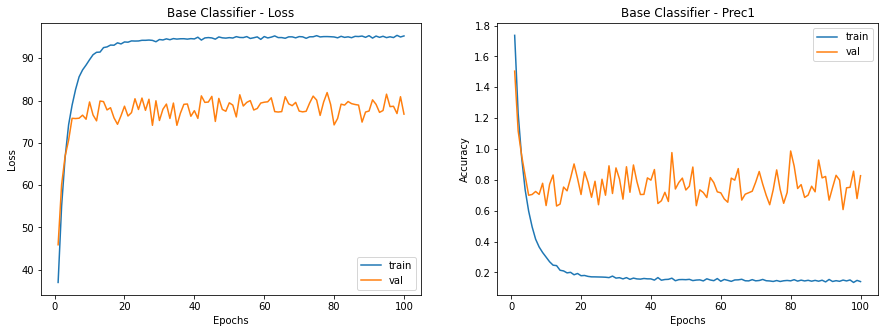

In [86]:
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(15)

fig.add_subplot(1, 2, 1)
sns.lineplot(data=logs, x='epoch', y='train_prec1', label='train')
sns.lineplot(data=logs, x='epoch', y='val_prec1', label='val')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Base Classifier - Loss')

fig.add_subplot(1, 2, 2)
sns.lineplot(data=logs, x='epoch', y='train_loss', label='train')
sns.lineplot(data=logs, x='epoch', y='val_loss', label='val')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Base Classifier - Prec1')

# Truncate CIFAR-10

In [4]:
base_classifier, _ = model_utils.make_and_restore_model(arch='resnet18', dataset=ds, resume_path=BASE_CLASSIFIER_PATH)

=> loading checkpoint '/home/gridsan/stefanou/cifar-10/resnet-18/base_constant_1e-1/ee9b9c47-426e-4d3b-861c-2c72958fbbbe/checkpoint.pt.latest'
=> loaded checkpoint '/home/gridsan/stefanou/cifar-10/resnet-18/base_constant_1e-1/ee9b9c47-426e-4d3b-861c-2c72958fbbbe/checkpoint.pt.latest' (epoch 100)


# Callibrate Base Classifier

In [5]:
from tqdm.notebook import tqdm

def T_scaling(logits, temp):
    return ch.div(logits, temp)

# Use kwargs for calibration method specific parameters
def test(base_classifier, calibration_method=None, temp=None):
    preds = []
    labels_oneh = []
    correct = 0
    base_classifier.eval()
    with ch.no_grad():
        for data in tqdm(test_loader):
            images, labels = data[0].to('cuda:0'), data[1].to('cuda:0')

            pred = base_classifier(images)[0]

            if calibration_method:
                pred = calibration_method(pred, temp)

            # Get softmax values for net input and resulting class predictions
            sm = nn.Softmax(dim=1)
            pred = sm(pred)

            _, predicted_cl = ch.max(pred.data, 1)
            pred = pred.cpu().detach().numpy()

            # Convert labels to one hot encoding
            label_oneh = ch.nn.functional.one_hot(labels, num_classes=num_classes)
            label_oneh = label_oneh.cpu().detach().numpy()

            preds.extend(pred)
            labels_oneh.extend(label_oneh)

            # Count correctly classified samples for accuracy
            correct += sum(predicted_cl == labels).item()

    preds = np.array(preds).flatten()
    labels_oneh = np.array(labels_oneh).flatten()

    correct_perc = correct / len(test_loader.dataset)
    print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct_perc))
    print(correct_perc)

    return preds, labels_oneh

preds, labels_oneh = test(base_classifier)

def calc_bins(preds):
    # Assign each prediction to a bin
    num_bins = 10
    bins = np.linspace(0.1, 1, num_bins)
    binned = np.digitize(preds, bins)

    # Save the accuracy, confidence and size of each bin
    bin_accs = np.zeros(num_bins)
    bin_confs = np.zeros(num_bins)
    bin_sizes = np.zeros(num_bins)

    for bin in range(num_bins):
        bin_sizes[bin] = len(preds[binned == bin])
        if bin_sizes[bin] > 0:
            bin_accs[bin] = (labels_oneh[binned==bin]).sum() / bin_sizes[bin]
            bin_confs[bin] = (preds[binned==bin]).sum() / bin_sizes[bin]

    return bins, binned, bin_accs, bin_confs, bin_sizes

def get_metrics(preds):
    ECE = 0
    MCE = 0
    bins, _, bin_accs, bin_confs, bin_sizes = calc_bins(preds)

    for i in range(len(bins)):
        abs_conf_dif = abs(bin_accs[i] - bin_confs[i])
        ECE += (bin_sizes[i] / sum(bin_sizes)) * abs_conf_dif
        MCE = max(MCE, abs_conf_dif)

    return ECE, MCE


import matplotlib.patches as mpatches

def draw_reliability_graph(preds):
    ECE, MCE = get_metrics(preds)
    bins, _, bin_accs, _, _ = calc_bins(preds)

    fig = plt.figure(figsize=(8, 8))
    ax = fig.gca()

    # x/y limits
    ax.set_xlim(0, 1.05)
    ax.set_ylim(0, 1)

    # x/y labels
    plt.xlabel('Confidence')
    plt.ylabel('Accuracy')

    # Create grid
    ax.set_axisbelow(True) 
    ax.grid(color='gray', linestyle='dashed')

    # Error bars
    plt.bar(bins, bins,  width=0.1, alpha=0.3, edgecolor='black', color='r', hatch='\\')

    # Draw bars and identity line
    plt.bar(bins, bin_accs, width=0.1, alpha=1, edgecolor='black', color='b')
    plt.plot([0,1],[0,1], '--', color='gray', linewidth=2)

    # Equally spaced axes
    plt.gca().set_aspect('equal', adjustable='box')

    # ECE and MCE legend
    ECE_patch = mpatches.Patch(color='green', label='ECE = {:.2f}%'.format(ECE*100))
    MCE_patch = mpatches.Patch(color='red', label='MCE = {:.2f}%'.format(MCE*100))
    plt.legend(handles=[ECE_patch, MCE_patch])

    #plt.show()

    plt.savefig('calibrated_network.png', bbox_inches='tight')

#draw_reliability_graph(preds)



Accuracy of the network on the 10000 test images: 76 %
0.7699



Final T_scaling factor: 1.65


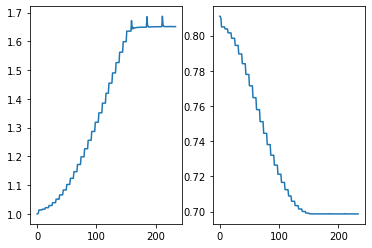

In [6]:
criterion = nn.CrossEntropyLoss()

# Removing strong_wolfe line search results in jump after 50 epochs
optimizer = ch.optim.LBFGS([args.temperature], lr=0.001, max_iter=10000, line_search_fn='strong_wolfe')

logits_list = []
labels_list = []
temps = []
losses = []

for i, data in enumerate(tqdm(test_loader, 0)):
    images, labels = data[0].cuda(), data[1].cuda()

    base_classifier.eval()
    with ch.no_grad():
        logits_list.append(base_classifier(images)[0])
        labels_list.append(labels)

# Create tensors
logits_list = ch.cat(logits_list).cuda()
labels_list = ch.cat(labels_list).cuda()

def _eval():
    loss = criterion(T_scaling(logits_list, args.temperature), labels_list)
    loss.backward()
    temps.append(args.temperature.item())
    losses.append(loss)
    return loss


optimizer.step(_eval)

print('Final T_scaling factor: {:.2f}'.format(args.temperature.item()))

plt.subplot(121)
plt.plot(list(range(len(temps))), temps)

plt.subplot(122)
plt.plot(list(range(len(losses))), losses)
plt.show()

In [7]:
def T_scaling(logits, temp):
    """
    Temperature scaling.
    """
    return ch.div(logits, temp)


def calibrate(test_loader, base_classifier): 
    """
    Run SGD procedure to find temperature 
    scaling parameter.
    Args: 
        test_loader (ch.nn.DataLoader) : pytorch DataLoader with test dataset
        base_classifier (AttackerModel) : AttackerModel to calibrate
    Returns: ch.Tensor with the calculated temperature scalar
    """
    temperature = ch.nn.Parameter(ch.ones(1).cuda())
    ce_loss = ch.nn.CrossEntropyLoss()

    # Removing strong_wolfe line search results in jump after 50 epochs
    optimizer = ch.optim.LBFGS([temperature], lr=0.001, max_iter=10000, line_search_fn='strong_wolfe')

    logits_list = []
    labels_list = []
    temps = []
    losses = []

    for images, labels in tqdm(test_loader, 0):
        images, labels = images.cuda(), labels.cuda()

        base_classifier.eval()
        with ch.no_grad():
            logits_list.append(base_classifier(images)[0])
            labels_list.append(labels)

    # create tensors
    logits_list = ch.cat(logits_list).cuda()
    labels_list = ch.cat(labels_list).cuda()

    def _eval():
        loss = ce_loss(T_scaling(logits_list, temperature), labels_list)
        loss.backward()
        temps.append(temperature.item())
        losses.append(loss)
        return loss

    # run SGD
    optimizer.step(_eval)
    
    print('Final T_scaling factor: {:.2f}'.format(temperature.item()))

    plt.subplot(121)
    plt.plot(list(range(len(temps))), temps)

    plt.subplot(122)
    plt.plot(list(range(len(losses))), losses)
    plt.show()
    
    return temperature


Final T_scaling factor: 1.65


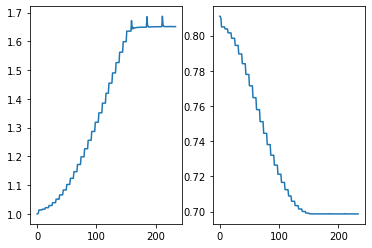


Accuracy of the network on the 10000 test images: 76 %
0.7699



Accuracy of the network on the 10000 test images: 76 %
0.7699


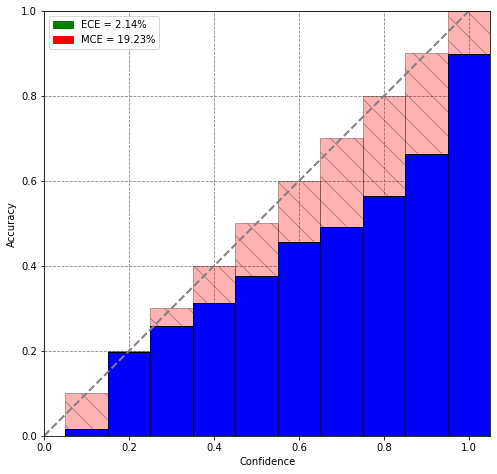

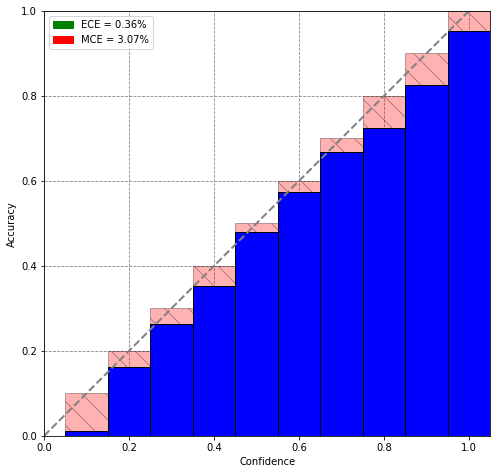

In [8]:
model = base_classifier
temp = calibrate(test_loader, model)


preds_original, _ = test(model)
preds_calibrated, _ = test(model, T_scaling, temp)

draw_reliability_graph(preds_original)
draw_reliability_graph(preds_calibrated)

In [9]:
orig_ece, orig_mce = get_metrics(preds_original)
calibrated_ece, calibrated_mce = get_metrics(preds_calibrated)

print("original ece: ", orig_ece)
print("original mce: ", orig_mce)

print("calibrated ece: ", calibrated_ece)
print("calibrated mce: ", calibrated_mce)

original ece:  0.021363844070030075
original mce:  0.19229504862972624
calibrated ece:  0.003616540527343751
calibrated mce:  0.030665445788718437


In [5]:
# membership oracle
phi = oracle.LogitBallComplement(args.logit_ball, ch.ones(1))

# check if there exists a cifar 10 train truncated dataset already
if not os.path.isfile(DATA_PATH + TRUNC_TRAIN_DATASET + str(args.logit_ball) + '.pickle') or not os.path.isfile(DATA_PATH + TRUNC_TRAIN_DATASET + str(args.logit_ball) + '.pickle'):
    trunc_train_X, trunc_train_y = Tensor([]), Tensor([])
    # unseen test data
    trunc_test_X, trunc_test_y = Tensor([]), Tensor([])
    for inp, targ in train_loader: 
        inp, targ = inp.to(args.device), targ.to(args.device)
        logits, inp = base_classifier(inp) 
        logits /= args.temperature.item()
        noised = logits
#         noised = logits + gumbel.sample(logits.size()).cuda()

        filtered = phi(noised)
        indices = filtered.nonzero(as_tuple=False).flatten()
        test_indices = (~filtered).nonzero(as_tuple=False).flatten()
        trunc_train_X, trunc_train_y = ch.cat([trunc_train_X, inp[indices].cpu()]), ch.cat([trunc_train_y, targ[indices].cpu()])
        trunc_test_X, trunc_test_y = ch.cat([trunc_test_X, inp[test_indices].cpu()]), ch.cat([trunc_test_y, targ[test_indices].cpu()])

    print("train alpha: ", trunc_train_X.size(0) / len(train_loader.dataset))
    trunc_train_loader = DataLoader(TruncatedCIFAR(trunc_train_X, trunc_train_y.long(), transform= None), num_workers=args.workers, shuffle=args.shuffle, batch_size=args.batch_size)

    # train loader
    with open(DATA_PATH + TRUNC_TRAIN_DATASET + str(args.logit_ball) + '.pickle', 'wb') as f: 
        pickle.dump(trunc_train_loader, f)
else:  
    trunc_train_loader = pd.read_pickle(DATA_PATH + TRUNC_TRAIN_DATASET + str(args.logit_ball) + '.pickle')
trunc_train_loader

In [7]:
# check if there exists a cifar 10 valdation and test truncated dataset
if not os.path.isfile(DATA_PATH + TRUNC_VAL_DATASET + str(args.logit_ball) + '.pickle') or not os.path.isfile(DATA_PATH + TRUNC_VAL_DATASET + str(args.logit_ball) + '.pickle'):
    trunc_val_X, trunc_val_y = Tensor([]), Tensor([]) 

    for inp, targ in val_loader: 
        inp, targ = inp.to(args.device), targ.to(args.device)
        logits, inp = base_classifier(inp) 
        logits /= args.temperature.item()

#         noised = logits + gumbel.sample(logits.size()).cuda()
        noised = logits

        filtered = phi(noised)
        indices = filtered.nonzero(as_tuple=False).flatten()
        test_indices = (~filtered).nonzero(as_tuple=False).flatten()
        trunc_val_X, trunc_val_y = ch.cat([trunc_val_X, inp[indices].cpu()]), ch.cat([trunc_val_y, targ[indices].cpu()])
        trunc_test_X, trunc_test_y = ch.cat([trunc_test_X, inp[test_indices].cpu()]), ch.cat([trunc_test_y, targ[test_indices].cpu()])

    print("val alpha: ", trunc_val_X.size(0) / len(val_loader.dataset))
    trunc_val_loader = DataLoader(TruncatedCIFAR(trunc_val_X, trunc_val_y.long(), transform=None), num_workers=args.workers, shuffle=args.shuffle, batch_size=args.batch_size)
    # truncated test set (unseen data that the model has not been tested on)
    trunc_test_loader = DataLoader(TruncatedCIFAR(trunc_test_X, trunc_test_y.long(), transform=None), 
                             num_workers=args.workers, shuffle=args.shuffle, batch_size=args.batch_size)

    # validation loader
    with open(DATA_PATH + TRUNC_VAL_DATASET + str(args.logit_ball) + '.pickle', 'wb') as f: 
        pickle.dump(trunc_val_loader, f)

    # test loader
    with open(DATA_PATH + TRUNC_TEST_DATASET + str(args.logit_ball) + '.pickle', 'wb') as f: 
        pickle.dump(trunc_test_loader, f)
else: 
    trunc_val_loader = pd.read_pickle(DATA_PATH + TRUNC_VAL_DATASET + str(args.logit_ball) + '.pickle')
    trunc_test_loader = pd.read_pickle(DATA_PATH + TRUNC_TEST_DATASET + str(args.logit_ball) + '.pickle')
trunc_val_loader, trunc_test_loader

(<torch.utils.data.dataloader.DataLoader at 0x7fdfdd591430>,
 <torch.utils.data.dataloader.DataLoader at 0x7fdf0a12b220>)

In [8]:
print("alpha train: ", len(trunc_train_loader.dataset) / len(train_loader.dataset))
print("alpha val: ", len(trunc_val_loader.dataset) / len(val_loader.dataset))
print("test set size: ", len(trunc_test_loader.dataset))

alpha train:  0.31022222222222223
alpha val:  0.306
test set size:  34510


In [9]:
out_store = store.Store(PRETRAIN)
setup_store_with_metadata(args, out_store)

Logging in: /home/gridsan/stefanou/cifar-10/resnet-18/pretrained_model/31574a46-8654-44b0-9dc7-b4eed8664cce


In [40]:
ch.manual_seed(0)
config.args = args
args.__setattr__('epochs', 2)
args.__setattr__('lr', 1e-1)
pretrained_model, _ = model_utils.make_and_restore_model(arch='resnet18', dataset=ds)
pretrained_model = train.train_model(args, pretrained_model, (trunc_train_loader, trunc_val_loader), store=out_store)
out_store.close()

In [27]:
reader = CollectionReader(PRETRAIN)
metadata = reader.df('metadata')
pretrain_logs = reader.df('logs')

reader.close()
pretrain_logs

100%|██████████| 1/1 [00:00<00:00, 92.65it/s]


,epoch,val_prec1,val_loss,train_prec1,train_loss,time,exp_id
0,1,67.539627,0.914099,51.740387,1.327770,7.393136,475830ba-40a7-4305-b0e6-fcf2ff17a5a9
1,2,85.596138,0.419825,72.138626,0.784278,14.691191,475830ba-40a7-4305-b0e6-fcf2ff17a5a9
2,3,87.388008,0.352095,82.459343,0.496294,22.303899,475830ba-40a7-4305-b0e6-fcf2ff17a5a9
3,4,85.527222,0.419174,88.625427,0.323057,28.819556,475830ba-40a7-4305-b0e6-fcf2ff17a5a9
4,5,88.697449,0.317957,93.043526,0.200093,36.208173,475830ba-40a7-4305-b0e6-fcf2ff17a5a9
...,...,...,...,...,...,...,...
95,96,96.967606,0.095975,99.994934,0.000932,639.401999,475830ba-40a7-4305-b0e6-fcf2ff17a5a9
96,97,97.450035,0.112669,99.782135,0.010382,645.922335,475830ba-40a7-4305-b0e6-fcf2ff17a5a9
97,98,97.312195,0.093608,99.989868,0.001884,652.436981,475830ba-40a7-4305-b0e6-fcf2ff17a5a9
98,99,97.725708,0.090153,100.000000,0.001021,659.926098,475830ba-40a7-4305-b0e6-fcf2ff17a5a9


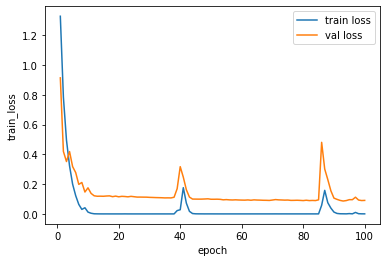

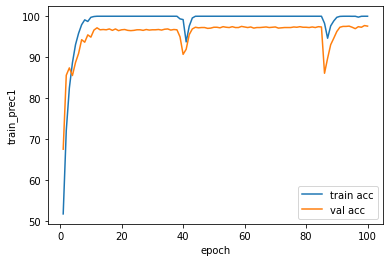

In [29]:
sns.lineplot(data=pretrain_logs, x='epoch', y='train_loss', label='train loss')
sns.lineplot(data=pretrain_logs, x='epoch', y='val_loss', label='val loss')
plt.show()

sns.lineplot(data=pretrain_logs, x='epoch', y='train_prec1', label='train acc')
sns.lineplot(data=pretrain_logs, x='epoch', y='val_prec1', label='val acc')
plt.show()

# Train Model Using Truncated CE Loss

In [10]:
##### logging store
out_store = store.Store(LOGIT_BALL_CLASSIFIER)
setup_store_with_metadata(args, out_store)
delphi_, _ = model_utils.make_and_restore_model(arch='resnet18', dataset=ds)
# delphi_, _ = model_utils.make_and_restore_model(arch='resnet18', dataset=ds, resume_path=PRETRAIN + '/475830ba-40a7-4305-b0e6-fcf2ff17a5a9/checkpoint.pt.latest')

Logging in: /home/gridsan/stefanou/cifar-10/resnet-18/constant_trunc_1e-1/22ab7ce6-e34f-43c9-8602-996291ba3209


# TruncatedCE with Logit Ball Complement Oracle

In [11]:
new_phi = oracle.LogitBallComplement(args.logit_ball)

In [12]:
# train
ch.manual_seed(0)
config.args = args
delphi_ = train.train_model(args, delphi_, (trunc_train_loader, trunc_val_loader), store=out_store, phi=phi, criterion=grad.TruncatedCE.apply)
out_store.close()

In [13]:
reader = CollectionReader(LOGIT_BALL_CLASSIFIER)
metadata = reader.df('metadata')
trunc_logs = reader.df('logs')

reader.close()
trunc_logs

100%|██████████| 24/24 [00:00<00:00, 129.34it/s]


,epoch,val_prec1,val_loss,train_prec1,train_loss,time,exp_id
0,1,50.608181,1.771880,41.522461,1.891616,19.250631,48497795-c146-4abf-8d8f-02c807825dc1
1,2,60.044231,1.655200,60.761230,1.628825,30.114234,48497795-c146-4abf-8d8f-02c807825dc1
2,3,66.420937,1.517112,69.708817,1.481930,40.110307,48497795-c146-4abf-8d8f-02c807825dc1
3,4,71.065239,1.429932,75.415970,1.367628,50.484125,48497795-c146-4abf-8d8f-02c807825dc1
4,5,73.866570,1.350700,80.103989,1.276389,60.637694,48497795-c146-4abf-8d8f-02c807825dc1
...,...,...,...,...,...,...,...
95,96,89.490700,0.387643,99.990982,0.001975,1297.577299,2f55d829-fcd7-4cf8-bb2d-557eedd85606
96,97,89.679329,0.388704,99.990982,0.001981,1311.703513,2f55d829-fcd7-4cf8-bb2d-557eedd85606
97,98,89.625435,0.379655,99.990982,0.001882,1326.124606,2f55d829-fcd7-4cf8-bb2d-557eedd85606
98,99,89.760170,0.377974,99.990982,0.001953,1340.428331,2f55d829-fcd7-4cf8-bb2d-557eedd85606


In [14]:
trunc_logs = trunc_logs[trunc_logs.exp_id == '22ab7ce6-e34f-43c9-8602-996291ba3209']

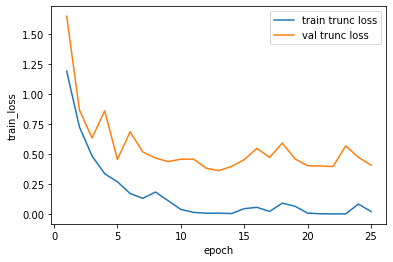

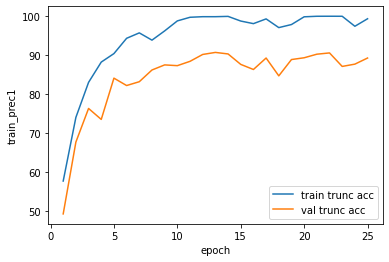

In [15]:
sns.lineplot(data=trunc_logs, x='epoch', y='train_loss', label='train trunc loss')
sns.lineplot(data=trunc_logs, x='epoch', y='val_loss', label='val trunc loss')
plt.show()

sns.lineplot(data=trunc_logs, x='epoch', y='train_prec1', label='train trunc acc')
sns.lineplot(data=trunc_logs, x='epoch', y='val_prec1', label='val trunc acc')
plt.show()

# Train Model on Standard CE Loss with Truncated Dataset

In [19]:
##### logging store
out_store = store.Store(STANDARD_CLASSIFIER)
setup_store_with_metadata(args, out_store)
standard, _ = model_utils.make_and_restore_model(arch='resnet18', dataset=ds)

Logging in: /home/gridsan/stefanou/cifar-10/resnet-18/constant_standard_1e-1/78ad3ce2-a995-4910-9f5d-43a4eda4e204


In [20]:
# train
ch.manual_seed(0)
config.args = args
standard_model = train.train_model(args, standard, (trunc_train_loader, trunc_val_loader), store=out_store, parallel=args.parallel)
out_store.close()

In [21]:
reader = CollectionReader(STANDARD_CLASSIFIER)
metadata = reader.df('metadata')
logs = reader.df('logs')
reader.close()
logs

100%|██████████| 12/12 [00:00<00:00, 96.06it/s]

,epoch,val_prec1,val_loss,train_prec1,train_loss,time,exp_id
0,1,70.762596,0.840600,55.941578,1.207754,12.295221,7ea9c3a0-78b5-42c1-8afc-c1fd23f36f76
1,2,77.229851,0.659898,76.107475,0.677678,23.859922,7ea9c3a0-78b5-42c1-8afc-c1fd23f36f76
2,3,78.469414,0.644482,84.086678,0.451265,35.616874,7ea9c3a0-78b5-42c1-8afc-c1fd23f36f76
3,4,76.717865,0.774262,89.763779,0.294545,47.175606,7ea9c3a0-78b5-42c1-8afc-c1fd23f36f76
4,5,80.140121,0.657786,93.421295,0.186519,59.044676,7ea9c3a0-78b5-42c1-8afc-c1fd23f36f76
...,...,...,...,...,...,...,...
20,21,89.019608,0.510278,99.469910,0.015208,109.781725,78ad3ce2-a995-4910-9f5d-43a4eda4e204
21,22,88.431374,0.403371,96.912605,0.096101,114.887932,78ad3ce2-a995-4910-9f5d-43a4eda4e204
22,23,90.196083,0.358824,99.699135,0.013214,119.995316,78ad3ce2-a995-4910-9f5d-43a4eda4e204
23,24,90.718956,0.350948,99.935524,0.003640,125.120353,78ad3ce2-a995-4910-9f5d-43a4eda4e204


In [22]:
logs = logs[logs.exp_id == '78ad3ce2-a995-4910-9f5d-43a4eda4e204']

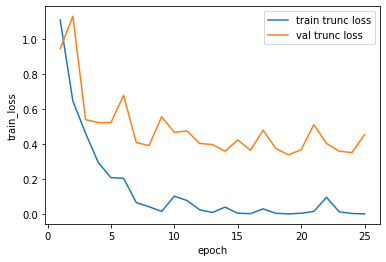

<AxesSubplot:xlabel='epoch', ylabel='train_prec1'>

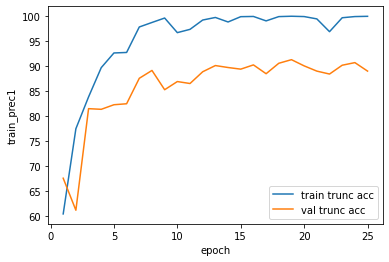

In [23]:
sns.lineplot(data=logs, x='epoch', y='train_loss', label='train trunc loss')
sns.lineplot(data=logs, x='epoch', y='val_loss', label='val trunc loss')
plt.show()

sns.lineplot(data=logs, x='epoch', y='train_prec1', label='train trunc acc')
sns.lineplot(data=logs, x='epoch', y='val_prec1', label='val trunc acc')

# Load Trained Models into Notebook

In [16]:
base, _ = model_utils.make_and_restore_model(arch='resnet18', dataset=ds, resume_path=BASE_CLASSIFIER_PATH)
delphi_, _ = model_utils.make_and_restore_model(arch='resnet18', dataset=ds, resume_path=LOGIT_BALL_CLASSIFIER + '/22ab7ce6-e34f-43c9-8602-996291ba3209/checkpoint.pt.best')
standard_model, _ =  model_utils.make_and_restore_model(arch='resnet18', dataset=ds, resume_path=STANDARD_CLASSIFIER + '/78ad3ce2-a995-4910-9f5d-43a4eda4e204/checkpoint.pt.best')





=> loading checkpoint '/home/gridsan/stefanou/cifar-10/resnet-18/base_constant_1e-1/ee9b9c47-426e-4d3b-861c-2c72958fbbbe/checkpoint.pt.latest'
=> loaded checkpoint '/home/gridsan/stefanou/cifar-10/resnet-18/base_constant_1e-1/ee9b9c47-426e-4d3b-861c-2c72958fbbbe/checkpoint.pt.latest' (epoch 100)
=> loading checkpoint '/home/gridsan/stefanou/cifar-10/resnet-18/constant_trunc_1e-1/22ab7ce6-e34f-43c9-8602-996291ba3209/checkpoint.pt.best'
=> loaded checkpoint '/home/gridsan/stefanou/cifar-10/resnet-18/constant_trunc_1e-1/22ab7ce6-e34f-43c9-8602-996291ba3209/checkpoint.pt.best' (epoch 13)
=> loading checkpoint '/home/gridsan/stefanou/cifar-10/resnet-18/constant_standard_1e-1/78ad3ce2-a995-4910-9f5d-43a4eda4e204/checkpoint.pt.best'
=> loaded checkpoint '/home/gridsan/stefanou/cifar-10/resnet-18/constant_standard_1e-1/78ad3ce2-a995-4910-9f5d-43a4eda4e204/checkpoint.pt.best' (epoch 19)


# Test Accuracy

In [17]:
delphi_store = store.Store(LOGIT_BALL_CLASSIFIER)

Logging in: /home/gridsan/stefanou/cifar-10/resnet-18/constant_trunc_1e-1/37be57e2-6dc3-46ec-a6a2-b95247d03a63


In [18]:
delphi_unseen_results = train.eval_model(args, delphi_, trunc_test_loader, delphi_store)
print("delphi unseen results: ", delphi_unseen_results)

delphi_test_results = train.eval_model(args, delphi_, test_loader, delphi_store)
print("delphi test results: ", delphi_test_results)

delphi_train_results = train.eval_model(args, delphi_, trunc_train_loader, delphi_store)
print("delphi train results: ", delphi_train_results)

delphi_val_results = train.eval_model(args, delphi_, trunc_val_loader, delphi_store)
print("delphi val results: ", delphi_val_results)
delphi_store.close()

delphi unseen results:  {'test_prec1': tensor(51.7386, device='cuda:0'), 'test_loss': 2.387062956588367, 'time': 3.6542460918426514}


delphi test results:  {'test_prec1': tensor(63.3600, device='cuda:0'), 'test_loss': 1.8148980253219604, 'time': 1.1003587245941162}


delphi train results:  {'test_prec1': tensor(99.9713, device='cuda:0'), 'test_loss': 0.0032771657043560954, 'time': 1.665579080581665}


delphi val results:  {'test_prec1': tensor(90.7190, device='cuda:0'), 'test_loss': 0.36190470838858413, 'time': 0.5180149078369141}


In [28]:
base_store = store.Store(BASE_CLASSIFIER)

Logging in: /home/gridsan/stefanou/cifar-10/resnet-18/base_constant_1e-1/4245051f-c852-4de8-b792-191b59161874


In [29]:
base_unseen_results = train.eval_model(args, base, trunc_test_loader, base_store)
print("base unseen results: ", base_unseen_results)

base_test_results = train.eval_model(args, base, test_loader, base_store)
print("base test results: ", base_test_results)

base_train_results = train.eval_model(args, base, trunc_train_loader, base_store)
print("base train results: ", base_train_results)

base_val_results = train.eval_model(args, base, trunc_val_loader, base_store)
print("base val results: ", base_val_results)
base_store.close()

base unseen results:  {'test_prec1': tensor(85.5086, device='cuda:0'), 'test_loss': 0.44084589434202015, 'time': 3.6963069438934326}


base test results:  {'test_prec1': tensor(76.9900, device='cuda:0'), 'test_loss': 0.8110041234970092, 'time': 1.0967600345611572}


base train results:  {'test_prec1': tensor(97.5573, device='cuda:0'), 'test_loss': 0.09759092076073125, 'time': 1.6967365741729736}


base val results:  {'test_prec1': tensor(97.5817, device='cuda:0'), 'test_loss': 0.09704786641340629, 'time': 0.4967989921569824}


In [30]:
standard_store = store.Store(STANDARD_CLASSIFIER)

Logging in: /home/gridsan/stefanou/cifar-10/resnet-18/constant_standard_1e-1/a1c4cf79-4a89-43e3-99cd-f1f8af63713e


In [31]:
standard_unseen_results = train.eval_model(args, standard_model, trunc_test_loader, standard_store)
print("standard unseen results: ", standard_unseen_results)

standard_test_results = train.eval_model(args, standard_model, test_loader, standard_store)
print("standard test results: ", standard_test_results)

standard_train_results = train.eval_model(args, standard_model, trunc_train_loader, standard_store)
print("standard train results: ", standard_train_results)

standard_val_results = train.eval_model(args, standard_model, trunc_val_loader, standard_store)
print("standard val results: ", standard_val_results)
standard_store.close()

standard unseen results:  {'test_prec1': tensor(53.9206, device='cuda:0'), 'test_loss': 2.1677965184081573, 'time': 3.6616673469543457}


standard test results:  {'test_prec1': tensor(64.7400, device='cuda:0'), 'test_loss': 1.654544499015808, 'time': 1.0848100185394287}


standard train results:  {'test_prec1': tensor(100., device='cuda:0'), 'test_loss': 0.0005435434026049215, 'time': 1.6563637256622314}


standard val results:  {'test_prec1': tensor(91.3072, device='cuda:0'), 'test_loss': 0.3380007635534199, 'time': 0.492495059967041}


4